# Titanic: Machine Learning from Disaster

In [1]:
# https://www.kaggle.com/c/titanic

In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8,8

In [3]:
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')
test_id = test['PassengerId']

In [4]:
for df in [train, test]:
    df['Prefix'] = df.Name.apply(lambda x: x[x.index(', ')+2:x.index('.')])
    df['Age'].fillna(value = df['Age'].median(), inplace = True)
    df['Fare'].fillna(value = df['Fare'].median(), inplace = True)
    df['Embarked'].fillna(value = 'S', inplace = True)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['has_cabin'] = df['Cabin'].apply(lambda x: 0 if x==None else 1)
    df['IsAlone']  = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
    df['Prefix'] = df['Prefix'].apply(lambda x: x if ((x=='Mr') | (x=='Miss') | (x=='Mrs') | (x=='Master')) else 'Rare')
    df['Fare_log'] = df.Fare.apply(lambda x: np.log(x+1))
    df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket', 'Fare'], axis = 1, inplace=True)

In [5]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,FamilySize,has_cabin,IsAlone,Fare_log
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.0,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,1.904602,1.0,0.602694,2.962246
std,0.486592,0.836071,13.019697,1.102743,0.806057,1.613459,0.0,0.489615,0.969048
min,0.000000,1.000000,0.420000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,1.000000,1.0,0.000000,2.187218
50%,0.000000,3.000000,28.000000,0.000000,0.000000,1.000000,1.0,1.000000,2.737881
75%,1.000000,3.000000,35.000000,1.000000,0.000000,2.000000,1.0,1.000000,3.465736
max,1.000000,3.000000,80.000000,8.000000,6.000000,11.000000,1.0,1.000000,6.240917


In [6]:
y_train = train.Survived
X_train = train.drop(['Survived'], axis = 1)
X_test = test

In [7]:
X_train = pd.get_dummies(X_train, columns=['Sex', 'Embarked', 'Pclass', 'Prefix'])
X_test = pd.get_dummies(X_test, columns=['Sex', 'Embarked', 'Pclass', 'Prefix'])
for df in [X_train, X_test]:
    df.drop(['Sex_female', 'Embarked_S', 'Pclass_3', 'Prefix_Rare'], axis = 1, inplace=True)

# GradientBoosting

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

In [10]:
def cross_val_predict_proba(estimator, X_train, y_train):
    kfold = KFold(n_splits=4, shuffle=True, random_state=None)
    return cross_val_predict(estimator, X_train, y_train, cv=kfold, method='predict_proba')

In [11]:
clf_gb = GradientBoostingClassifier(max_depth=1, learning_rate=0.09, random_state=42)

param_grid_gb = {'n_estimators':range(100,200,1)}

CV = KFold(n_splits=4, shuffle=True, random_state=42)
grid_gb = GridSearchCV(clf_gb, param_grid_gb, scoring='f1', cv=4)

grid_gb.fit(X_train, y_train)

print(grid_gb.best_params_)
print(grid_gb.best_score_)

{'n_estimators': 154}
0.771916997257


In [12]:
gb_train_pred = cross_val_predict_proba(grid_gb.best_estimator_, X_train, y_train)
gb_test_pred = grid_gb.best_estimator_.fit(X_train, y_train).predict_proba(X_test)

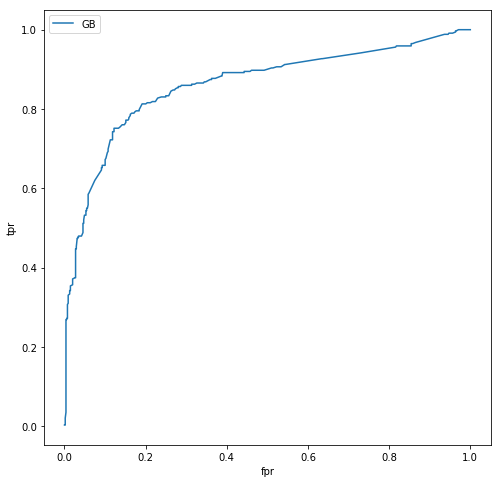

In [14]:
fpr, tpr, thresholds = roc_curve(y_train, gb_train_pred[:,1])
plt.plot(fpr,tpr)
plt.legend(['GB'])
plt.xlabel('fpr')
plt.ylabel('tpr')

# Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
clf_lr = LogisticRegression()

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X = X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
param_grid_lr = {'C': np.logspace(-5,5,11)}

grid_lr = GridSearchCV(clf_lr, param_grid_lr, scoring='f1', cv=4)

grid_lr.fit(X_train_scaled, y_train)

print(grid_lr.best_params_)
print(grid_lr.best_score_)

{'C': 0.10000000000000001}
0.764432153751


In [19]:
lr_train_pred = cross_val_predict_proba(grid_lr.best_estimator_, X_train_scaled, y_train)
lr_test_pred = grid_lr.best_estimator_.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

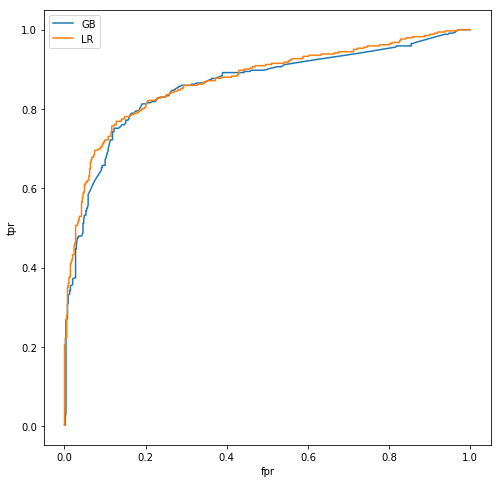

In [20]:
fpr1, tpr1, thresholds1 = roc_curve(y_train, lr_train_pred[:,1])
plt.plot(fpr,tpr)
plt.plot(fpr1,tpr1)
plt.legend(['GB', 'LR'])
plt.xlabel('fpr')
plt.ylabel('tpr')

# RandomForest

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
clf_rf = RandomForestClassifier(random_state=42)

param_grid_rf = {'n_estimators': range(150,200)}

grid_rf = GridSearchCV(clf_rf, param_grid_rf, scoring='f1', cv=4)

grid_rf.fit(X_train_scaled, y_train)

print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'n_estimators': 196}
0.73797903805


In [23]:
rf_train_pred = cross_val_predict_proba(grid_rf.best_estimator_, X_train_scaled, y_train)
rf_test_pred = grid_rf.best_estimator_.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

In [24]:
fpr2, tpr2, thresholds2 = roc_curve(y_train, rf_train_pred[:,1])

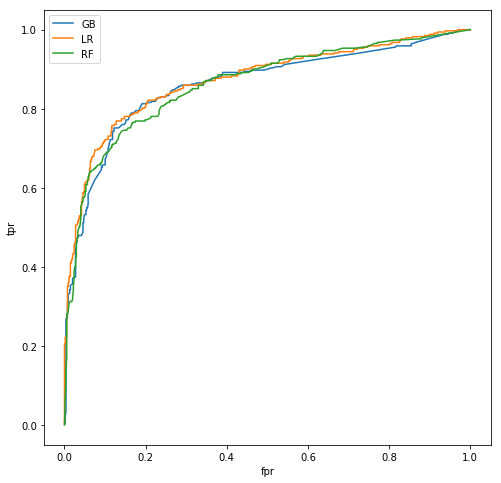

In [25]:
plt.plot(fpr,tpr)
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.legend(['GB', 'LR', 'RF'])
plt.xlabel('fpr')
plt.ylabel('tpr')

# Stacking

In [26]:
X_train_stack = np.stack([
   gb_train_pred[:,1], 
    lr_train_pred[:,1], 
    rf_train_pred[:,1]
], axis=1)

X_test_stack = np.stack([
    gb_test_pred[:,1], 
    lr_test_pred[:,1], 
    rf_test_pred[:,1]
], axis=1)

In [27]:
LogReg = LogisticRegression(random_state=42)

param_grid_logreg = {'C': np.logspace(-5,5,11)}

grid_logreg = GridSearchCV(LogReg, param_grid_logreg, scoring='accuracy', cv=4)

grid_logreg.fit(X_train_stack, y_train)

print(grid_logreg.best_score_)
print(grid_logreg.best_params_)

0.837261503928
{'C': 0.01}


In [28]:
train_pred = cross_val_predict_proba(grid_logreg.best_estimator_, X_train_stack, y_train)
predicted = grid_logreg.best_estimator_.fit(X_train_stack, y_train).predict(X_test_stack)

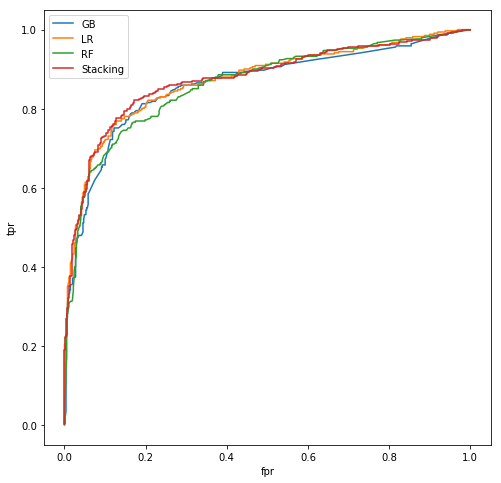

In [30]:
fpr3, tpr3, thresholds3 = roc_curve(y_train, train_pred[:,1])
plt.plot(fpr,tpr)
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.plot(fpr3,tpr3)
plt.legend(['GB', 'LR', 'RF', 'Stacking'])
plt.xlabel('fpr')
plt.ylabel('tpr')

In [34]:
print('ROC-AUC GB', roc_auc_score(y_train, gb_train_pred[:,1]))
print('ROC-AUC LR', roc_auc_score(y_train, lr_train_pred[:,1]))
print('ROC-AUC RF', roc_auc_score(y_train, rf_train_pred[:,1]))
print('ROC-AUC Stacking', roc_auc_score(y_train, train_pred[:,1]))
print('Kaggle score(accuracy): 0,79904')

ROC-AUC GB 0.860519924584
ROC-AUC LR 0.872348981135
ROC-AUC RF 0.862210931092
ROC-AUC Stacking 0.874796280318
Kaggle score(accuracy): 0,79904


## Create submission 

In [32]:
with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test_id, predicted):
        out.write('%s,%s\n' % (passenger, y))